<h1><center>How was last year? Exploring New York Times world news over 1 year time span</center></h1>

# 1. Project Background

In a fast paced society being able to share information as fast as possible is key for growth. Data science comes in aid trying to process these informations and return them back in a usable and readeable way. To me, one of the most interesting applications for Data Science is the one that involves text analysis and Natural Language Processing (NLP). There are numerous books and publications about this subject and it's not hard to understand why: being able to make a computer process and understand human language is fascinating and nevertheless challenging. 

Having the possibility to evaluate in a blink of an eye what a time period has been characterized of by analyzing news is the point of focus of this study - condensing them in few graphs or charts giving simple answers to more complex data. With this project I wanted to apply text analysis techniques ad more in general exploratory data analysis to understand how did the past 12 months go judging from the world standpoint. In my opinion it is interesting to let a machine elaborate some refined data to have insights and outcomes on a certain period based on news and articles. Thus, I will measure and explore varius indicators that can give us an idea of the main topics, subjects and words that characterized the world last year. Also I wanted to discover some hidden patterns that could not be seen at first without a deeper analysis. For example, will Covid be the first topic amongst all or there will be some other topic on top of the list? I will try to answer these questions by exploring the data.

Altough the data available is fairly huge, the main limitation of this study could be not having acces to the full articles but only to the titles, abstracts and few others text sections. This could imply that our text analysis will be less precise or that simply extracting information from only the few lines of text could not be enough to have useful insights. I will try to address it extracting as much text information as possible from the retrived data.

Also, even if not expected, at the end of the study there might be some findings that could lead to "harmful assumptions". For example some topics that we judge as positive are instead judged negatively by the sentiment analysis or some topics being more often utilized than others could lead to some degree of discrimination depending on our line of thinking. I will try to address this being as objective as possible.

Throughout the study we will look for:

* Feature insights (eg. most used keywords, top subsection, etc.)
* Vocabulary diversity
* Most used words
* WordCloud visualization
* Sentiment analysis

## 1.1 Data

![Data provided by The New York Times](https://developer.nytimes.com/files/poweredby_nytimes_200a.png?v=1583354208344)

I decided to collect news information using  <a href="https://developer.nytimes.com/apis">New York Times public APIs</a> and specifically the Archive API that returns an array of NYT articles for a given month, going back to 1851. All data is provided by The New York Times - this source has been specifically choosen because it is widely recognized as a respectable and important source.

While using their APIs we need to make sure to not break their <a href="https://help.nytimes.com/hc/en-us/articles/115014893">Terms of service</a> and to comply with their API call limit:
* 4000 requests per day
* 10 requests per minute
  * Sleep our script 6 seconds to avoid hitting the per minute rate limit

Data is returned as JSON and will be structured as follows after being processed:

| Headline | Print Headline | Lead Paragraph | Abstract | Document Type | Keywords | News_desk | Section Name | Subsection Name | Word count | Date |
|----------|----------------|----------------|----------|---------------|----------|-----------|--------------|-----------------|------------|------|
| OBJ      | OBJ            | OBJ            | OBJ      | OBJ           | OBJ      | OBJ       | OBJ          | OBJ             | INT        | OBJ  |

## 1.2 Data Processing

The study will be structured as follows:

1. Pull data from the NYT APIs and process it
2. Reduce the dataset to the sole "World" section articles
   1. This will imply some data cleaning techniques
3. Save the new reduced dataframe as .csv - this will also comply with the assignment constrain of having a 10MB< dataset
4. Data cleaning and feature engineering
5. Proceed with Exploratory Data Analysis (EDA)
6. Conclusions and considerations

# 2 Data Retreiving

Let's start by retrieving data from the API.

In [292]:
#import libraries and modules
import requests
import json
import datetime
import time

import pandas as pd
import numpy as np
from numpy import arange
from ast import literal_eval
import collections

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
from rake_nltk import Rake
from keybert import KeyBERT

import nltk
nltk.download("wordnet")
nltk.download("stopwords")
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon") # load the Lexicon that quantifies polar sentiment (positive/negative)
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\massi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\massi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\massi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [293]:
#creating the "data" variable using making a request to the API
response = requests.get("https://api.nytimes.com/svc/archive/v1/2021/10.json?api-key=nAI3eDl8Go6oj8eEi06R84NLgIHDBo9D")

data = json.loads(response.text)

Let's check the JSON keys and what is a single article composed of:

In [294]:
data["response"]["docs"][0].keys()

dict_keys(['abstract', 'web_url', 'snippet', 'lead_paragraph', 'print_section', 'print_page', 'source', 'multimedia', 'headline', 'keywords', 'pub_date', 'document_type', 'news_desk', 'section_name', 'subsection_name', 'byline', 'type_of_material', '_id', 'word_count', 'uri'])

In [295]:
data["response"]["docs"][0]

{'abstract': 'Are you a “poor historian,” “well nourished” or in need of a “time out”? As patients gain access to their own medical records, the notes left by doctors can sting.',
 'web_url': 'https://www.nytimes.com/2021/09/30/well/live/medical-records-misunderstanding.html',
 'snippet': 'Are you a “poor historian,” “well nourished” or in need of a “time out”? As patients gain access to their own medical records, the notes left by doctors can sting.',
 'lead_paragraph': 'Have you ever been insulted by your own medical records?',
 'print_section': 'D',
 'print_page': '6',
 'source': 'The New York Times',
 'multimedia': [{'rank': 0,
   'subtype': 'xlarge',
   'caption': None,
   'credit': None,
   'type': 'image',
   'url': 'images/2021/10/12/well/30Well-NL1/30Well-NL1-articleLarge.jpg',
   'height': 400,
   'width': 600,
   'subType': 'xlarge',
   'crop_name': 'articleLarge',
   'legacy': {'xlarge': 'images/2021/10/12/well/30Well-NL1/30Well-NL1-articleLarge.jpg',
    'xlargewidth': 600

By a quick look we can tell that there are some similarities between the keys of each articles (eg. abstract and snippet), and others that don't contain useful informations for our investigation (eg. print section or print page). Each article is composed of:
* Abstract
* Web Url
* Snippet - often equal to the abstract
* Lead paragraph - might equals the abstract
* Print Section
* Print Page
* Source
* Multimedia
* Headline
  * main
  * print headline
* Keywords
* Publication Date
* Document Type
* News desk
* Section Name
* Subsection Name
* Byline
* Type of Material
* Id
* Wordcount
* uri

We will focus our analysis on extracting as much useful text as possible, therefore we will proceed with the following keys: Headline, Print Headline, Lead Paragraph, Abstract, Document Type, Keywords, News Desk, Section Name, Subsection Name, Word Count and Date.

To scrape each article we need to make a request specifying the month and the year (/{year}/{month}.json). We need to create first a list of dates that we want to get information from to be able to proceed.
Please note how the base date has been fixed to avoid the data to change.

In [296]:
# base = datetime.datetime.today() - use this in case you want to start the analysis from today. Please note that EDA is valid from the 1/11/2021 and back
base = datetime.datetime(2021,11,1,00,6,56,0) # creating the base date to start our analysis from

months = [(base - datetime.timedelta(days=x)).month for x in range(365)] #making a list of the past 12 months
years = [(base - datetime.timedelta(days=x)).year for x in range(365)] # making a list of years for each month

dates = list(dict.fromkeys(zip(years, months))) #creating the list of pairs (year, month)

In [297]:
#creating a dictionary to store data from each key for each article

def nyt_articles(dates):
    """
    This function retreive the articles data give a list of tuples (year, months).
    Each article will have the following structure: headline, abstract, document_type, type_of_material, keywords, news desk, section name, subsection name, word count, date.

    Args:
        dates (list): list of tuples containing (year, months)

    Returns:
        dict: A dictionary containing the articles informations
    """
    
    articles = {
        
        "headline":[],
        "print_headline":[],
        "lead_paragraph":[],
        "abstract":[], 
        "document_type":[],
        "type_of_material":[],
        "keywords":[], 
        "news_desk":[],
        "section_name":[], 
        "subsection_name":[],
        "word_count":[], 
        "date":[]
        
    }

    for date in dates:
        response = requests.get(f"https://api.nytimes.com/svc/archive/v1/{date[0]}/{date[1]}.json?api-key=nAI3eDl8Go6oj8eEi06R84NLgIHDBo9D")

        data = json.loads(response.text)
        
        for article in data["response"]["docs"]:
            #appending headline
            articles["headline"].append(article["headline"]["main"])
            
            #appending print_headline
            #some articles don't have print_headline, we will use nan instead
            try:
                articles["print_headline"].append(article["headline"]["print_headline"])
            except:
                articles["print_headline"].append(np.nan) 
            
            #appending lead paragraph
            #some articles don't have lead paragraph, we will use nan instead
            try: 
                articles["lead_paragraph"].append(article["lead_paragraph"])
            except:
                articles["lead_paragraph"].append(np.nan)
            
            #appending abstract
            articles["abstract"].append(article["abstract"])
            
            #appending document type
            articles["document_type"].append(article["document_type"])
            
            #appending type_of_material
            articles["type_of_material"].append(article["type_of_material"])
            
            #appending keywords
            articles["keywords"].append([keyword["value"] for keyword in article["keywords"]])
            
            #appending news desk
            articles["news_desk"].append(article["news_desk"])
            
            #appending section name
            articles["section_name"].append(article["section_name"])
            
            #appending subsection name
            #some articles don't have subsection name, we will use nan instead
            try: 
                articles["subsection_name"].append(article["subsection_name"])
            except:
                articles["subsection_name"].append(np.nan)
            
            #appending word count
            articles["word_count"].append(article["word_count"])
            
            #appending date
            articles["date"].append(article["pub_date"])
        
        time.sleep(6) #to avoid hitting per minute rate limit
    
    return articles

In [298]:
articles = nyt_articles(dates)

In [299]:
#creating pandas dataframe from the dict
df = pd.DataFrame(articles)

In [300]:
#let's check first the head of the dataframe and its first 5 rows
df.head(5)

,headline,print_headline,lead_paragraph,abstract,document_type,type_of_material,keywords,news_desk,section_name,subsection_name,word_count,date
0,Why a Pilot Is Under Investigation for Saying ...,Airline Contrite After a Pilot Mocks Biden,It began as a chant at a NASCAR race. It becam...,His remarks went viral after he repeated the c...,article,News,"[AIRLINES AND AIRPLANES, Pilots, Southwest Air...",National,U.S.,NaN,477,2021-11-01T00:06:56+0000
1,"‘Succession’ Season 3, Episode 3: Head Spaces ...",,(Check out a recap of the latest episode in Se...,There was plenty of petty Roy cruelty to go ar...,article,News,"[Television, Succession (TV Program)]",Culture,Arts,Television,1502,2021-11-01T02:01:06+0000
2,Your Monday Briefing,,Presidents and prime ministers are gathering i...,Deciding the future of the climate.,article,briefing,[],NYTNow,Briefing,NaN,1270,2021-11-01T02:13:41+0000
3,What Is a ‘Carbon Footprint’? And 12 Other Cli...,Decoding the Buzzwords Around the Climate Debate,As climate change discussions take center stag...,As climate change discussions take center stag...,multimedia,Interactive Feature,"[Global Warming, Environment, Sustainable Living]",Climate,Climate,NaN,0,2021-11-01T02:28:31+0000
4,"‘Insecure’ Recap, Season 5, Episode 2: Pick Up...",,(Read the recap of the latest episode in Seaso...,"Busy with their careers and friendship, Issa a...",article,News,"[Television, Insecure (TV Program), Rae, Issa,...",Styles,Arts,Television,1009,2021-11-01T02:31:03+0000


# 3. Dataset reduction

Let's check how many entries and features we have:

In [301]:
df.shape

(59864, 12)

In [302]:
df.columns

Index(['headline', 'print_headline', 'lead_paragraph', 'abstract',
       'document_type', 'type_of_material', 'keywords', 'news_desk',
       'section_name', 'subsection_name', 'word_count', 'date'],
      dtype='object')

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59864 entries, 0 to 59863
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   headline          59864 non-null  object
 1   print_headline    59864 non-null  object
 2   lead_paragraph    59864 non-null  object
 3   abstract          59864 non-null  object
 4   document_type     59864 non-null  object
 5   type_of_material  59864 non-null  object
 6   keywords          59864 non-null  object
 7   news_desk         59864 non-null  object
 8   section_name      59864 non-null  object
 9   subsection_name   22689 non-null  object
 10  word_count        59864 non-null  int64 
 11  date              59864 non-null  object
dtypes: int64(1), object(11)
memory usage: 5.5+ MB


It looks like the number of null values in each column is zero apart from the subsection name, we will investigate this further. Also the only int type column is word count

I Will replace empty strings and enmpty lists to NaN

In [304]:
#let's check if there are any entries as empty strings
np.where(df.applymap(lambda x: x == ''))

(array([    1,     2,     4, ..., 59862, 59863, 59863], dtype=int64),
 array([1, 1, 1, ..., 1, 1, 7], dtype=int64))

In [305]:
#let's replace all the empty strings with nan
df = df.replace(r'^$', np.nan, regex=True)

In [306]:
#Also by the first 5 rows of the df we notice that the Keywords feature might contain empty lists. Let's replace empty lists in the keywords column with nan
df["keywords"] = df["keywords"].apply(lambda x: np.nan if len(x)==0 else x)

In [307]:
#let's check again our dataframe
df.info()
#this time we can see that we have quite a lot of missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59864 entries, 0 to 59863
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   headline          59857 non-null  object
 1   print_headline    31218 non-null  object
 2   lead_paragraph    59355 non-null  object
 3   abstract          59802 non-null  object
 4   document_type     59864 non-null  object
 5   type_of_material  56536 non-null  object
 6   keywords          53742 non-null  object
 7   news_desk         58442 non-null  object
 8   section_name      58988 non-null  object
 9   subsection_name   22689 non-null  object
 10  word_count        59864 non-null  int64 
 11  date              59864 non-null  object
dtypes: int64(1), object(11)
memory usage: 5.5+ MB


After replacing some empty entries with NaN we can see now that there are plenty of missing values

In [308]:
#missing values per feature
df.isna().sum()

headline                7
print_headline      28646
lead_paragraph        509
abstract               62
document_type           0
type_of_material     3328
keywords             6122
news_desk            1422
section_name          876
subsection_name     37175
word_count              0
date                    0
dtype: int64

In [309]:
#total sum of missing values
df.isna().sum().sum()

78147

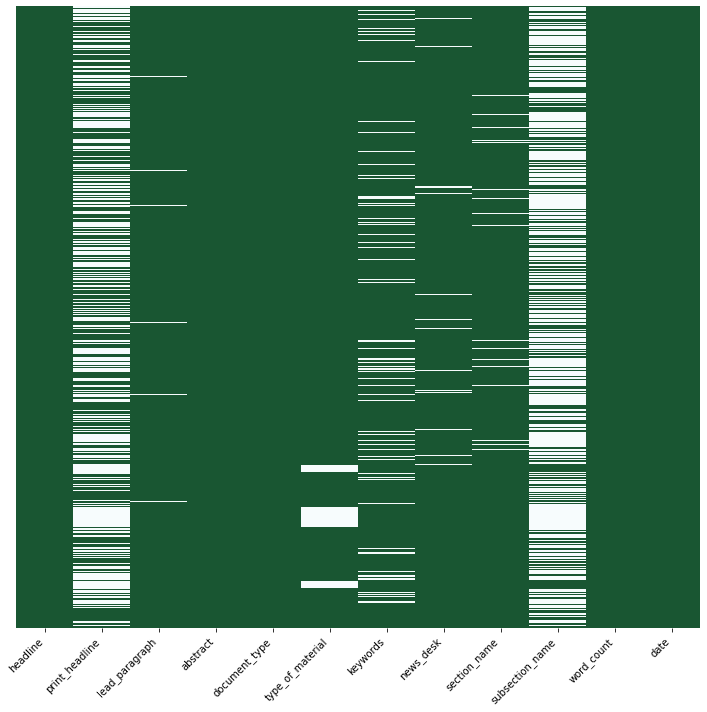

In [310]:
#visualize the missing values
ax, fig = plt.subplots(figsize=(10,10))

ax = sns.heatmap(df.isna(),yticklabels=False,cbar=False,cmap='BuGn_r', alpha = 0.9)

plt.xticks(rotation = 45, ha="right")

plt.tight_layout()

#note that low number of missings won't show in the chart

We can see that there is an high number of missing values. Before working on the features to remove missing data, since we want to analyse our dataframe only to the World news, we will first proceed to reduce our dataframe entries. This will avoid as well wasting energy cleaning features whose entries won't be used for our scope.

In [311]:
df["news_desk"].describe()

count       58442
unique         86
top       Foreign
freq         5926
Name: news_desk, dtype: object

For News Desk we will consider "World" and "Foreign", being more relevant to our scope

In [312]:
df["news_desk"].unique()

array(['National', 'Culture', 'NYTNow', 'Climate', 'Styles', 'Learning',
       'Sports', 'Foreign', 'Summary', 'OpEd', 'Games', 'Business',
       'Metro', 'Magazine', 'RealEstate', 'SpecialSections', 'Washington',
       'Dining', 'Travel', 'The Learning Network', 'Podcasts', 'Books',
       'BookReview', 'Real Estate', 'Express', 'Obits', 'Letters',
       'Science', 'U.S.', 'Well', 'World', 'Guide', 'Politics', nan,
       'Arts&Leisure', 'NewsDesk', 'TStyle', 'Corrections',
       'Business Day', 'The Upshot', 'Insider', 'Food', 'Graphics',
       'Weekend', 'Editorial', 'Opinion', 'Arts', 'Health', 'AtHome',
       'Upshot', 'Neediest', 'Parenting', 'Metropolitan',
       'Smarter Living', 'Investigative', 'New York', 'Briefing',
       'SundayBusiness', 'Admin', 'Theater', 'Universal', 'Español',
       'Multimedia/Photos', 'Watching', 'Style', 'Neediest Cases',
       'Gender', 'T Magazine', 'Technology', 'Live', 'Your Money',
       'Video', 'Movies', 'SundayReview', 'Obituari

In [313]:
#let's check again the number of missing in news desk
df["news_desk"].isna().value_counts(normalize=True)*100

False    97.624616
True      2.375384
Name: news_desk, dtype: float64

Around 2.4% of the values are missing. In this case, since the entries in section name are similar if not identical in some cases, we can be safe by substituing the missing values with the corresponding ones in the section name column

In [314]:
# let's substitute them with the values in the section name column
df["news_desk"]=df["news_desk"].fillna(df["section_name"])

In [315]:
df["news_desk"].isna().sum()

1

We still have one nan value - let's check it out

In [316]:
df[df["news_desk"].isna()]

,headline,print_headline,lead_paragraph,abstract,document_type,type_of_material,keywords,news_desk,section_name,subsection_name,word_count,date
55077,2019: The Year in Visual Stories and Graphics,NaN,"Selected Times graphics, visualizations and mu...","Selected Times graphics, visualizations and mu...",multimedia,NaN,NaN,NaN,NaN,NaN,0,2020-11-03T03:19:46+0000


In [317]:
df.loc[55077]["headline"]

'2019: The Year in Visual Stories and Graphics'

It's a multimedia document with not much information we can extract, also many other values are missing, we can drop this row safely.

In [318]:
df.dropna(subset=["news_desk"], axis=0, inplace=True)
df["news_desk"].isna().sum()

0

Let's reduce now the dataframe and save to csv

In [319]:
#let's reduce the dataframe and reset its index
df = df[(df["news_desk"]=="World") | (df["news_desk"]=="Foreign")]
df.reset_index(drop=True, inplace=True)

In [320]:
#let's save the dataframe to csv
df.to_csv("articles_world.csv", na_rep="NULL", encoding="utf-8", index=False) #na_rep is to save nan values as "NULL"

# 4 Data Cleaning and Feature Engineering

In [321]:
sentinels = ["NULL","","[]"] #creating a sentinel list to filter null values

In [322]:
#let's create the new dataframe
df_world = pd.read_csv("articles_world.csv", encoding="utf-8", na_values=sentinels)

In [323]:
#let's check the dtypes
df_world.dtypes

headline            object
print_headline      object
lead_paragraph      object
abstract            object
document_type       object
type_of_material    object
keywords            object
news_desk           object
section_name        object
subsection_name     object
word_count           int64
date                object
dtype: object

Converting the data to csv and then retreiving it made the Keywords feature change from lists to strings. Let's make the keyword feature a list

In [324]:
type(df_world["keywords"][0])

str

In [325]:
#Let's make the keyword feature a list
df_world["keywords"] = df_world["keywords"].apply(lambda row: literal_eval(row) if row is not np.nan else row) #converting to a list if the entry is not nan

In [326]:
type(df_world["keywords"][0])

list

In [327]:
df_world.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6267 entries, 0 to 6266
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   headline          6267 non-null   object
 1   print_headline    3362 non-null   object
 2   lead_paragraph    6243 non-null   object
 3   abstract          6262 non-null   object
 4   document_type     6267 non-null   object
 5   type_of_material  6267 non-null   object
 6   keywords          5883 non-null   object
 7   news_desk         6267 non-null   object
 8   section_name      6267 non-null   object
 9   subsection_name   4699 non-null   object
 10  word_count        6267 non-null   int64 
 11  date              6267 non-null   object
dtypes: int64(1), object(11)
memory usage: 587.7+ KB


We now have 6267 entries and missing some values in different fatures

Let's visualize again the missing data

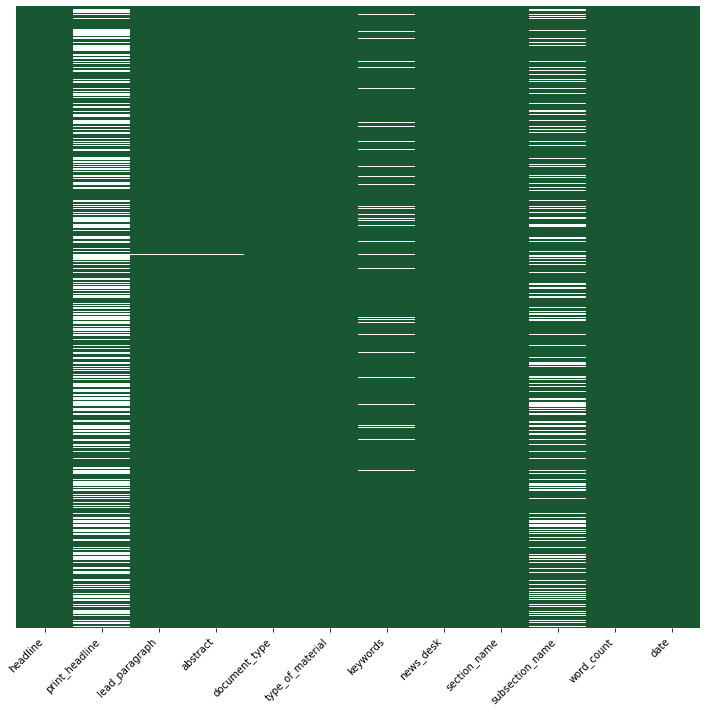

In [328]:
#visualize the missing values
ax, fig = plt.subplots(figsize=(10,10))

ax = sns.heatmap(df_world.isna(),yticklabels=False,cbar=False,cmap='BuGn_r', alpha = 0.9)

plt.xticks(rotation = 45, ha="right")

plt.tight_layout()

#note that low number of missings won't show in the chart

We still have quite a lot of missing data especially in print_headline and subsection_name but far less for the other features

In [329]:
df_world.isna().sum()

headline               0
print_headline      2905
lead_paragraph        24
abstract               5
document_type          0
type_of_material       0
keywords             384
news_desk              0
section_name           0
subsection_name     1568
word_count             0
date                   0
dtype: int64

Let's check each feature one by one and clean our data properly

### 4.1 Headline

In [330]:
df_world["headline"].describe()

count                     6267
unique                    6172
top       Your Friday Briefing
freq                        20
Name: headline, dtype: object

Looks like the top entry is a briefineg about what happended on friday. Let's investigate this further.

In [331]:
df_world["headline"].value_counts(normalize=True)[:5]*100

Your Friday Briefing       0.319132
Your Monday Briefing       0.303175
Your Tuesday Briefing      0.303175
Your Wednesday Briefing    0.303175
Your Thursday Briefing     0.287219
Name: headline, dtype: float64

Top 5 headlines are about the daily briefings. I didn't expect any headline to repeat but I was not taking into account all the daily briefings or weekly columns.

### 4.2 Print Headline

In [332]:
df_world["print_headline"].describe()

count                                                  3362
unique                                                 3362
top       Once a Leading Polluter, Britain Is Trying to ...
freq                                                      1
Name: print_headline, dtype: object

In this case all the print_headline are unique

In [333]:
df_world["print_headline"].value_counts(normalize=True)*100

Once a Leading Polluter, Britain Is Trying to Lead on Climate Change                  0.029744
The Return of a Maestro Draws Bravos in Rome                                          0.029744
Drug Regulator Assures Europe Vaccine Is Safe                                         0.029744
At Least 9 Die in Crash of Afghan Military Copter After Clashes With Local Militia    0.029744
Delivery Delay Slows Britain’s Vaccination Drive                                      0.029744
                                                                                        ...   
Veterans Were Promised Noble Cause in Haiti                                           0.029744
Chinese Female Directors Are Embracing Stories. Moviegoers Are Loving It.             0.029744
Reunited After 24 Years, a Son and Parents Who Didn’t Stop Searching                  0.029744
Afghan City Feels Taliban Tighten Vise                                                0.029744
Hong Kong’s Courts, Still Independent, Face New Th

Nothing too strange here, let's look now the missing values.

In [334]:
df_world["print_headline"].isna().sum()

2905

Unfortunately amost 50% of the print headline is missing. Generally when there's this high number of missing values we could drop the feature without too many issues. But since our ultimate goal is to extract as many information from the text as possible, we will keep this feature to build a corpus later.

### 4.3 Lead Paragraph

In [335]:
df_world["lead_paragraph"].describe()

count                                                  6243
unique                                                 6187
top       (Want to get this briefing by email? Here’s th...
freq                                                     10
Name: lead_paragraph, dtype: object

In [336]:
df_world["lead_paragraph"].value_counts(normalize=True)[:5]*100

(Want to get this briefing by email? Here’s the sign-up.)                                                             0.160179
To hear more audio stories from publications like The New York Times, download Audm for iPhone or Android.            0.096108
Follow our live coverage of the migrant crisis at the Belarus-Poland border.                                          0.096108
This obituary is part of a series about people who have died in the coronavirus pandemic. Read about others here.     0.048054
[Update: After nearly a week, the Ever Given, the mammoth container ship stuck in the Suez Canal, has been freed.]    0.048054
Name: lead_paragraph, dtype: float64

Again, nothing too strange. We can see that the briefing lead_paragraph is the most repeated one since brifiengs are happening daily. Let's check the missing values

In [337]:
df_world["lead_paragraph"].isna().sum()
#only 24

24

In [338]:
df_world[df_world["lead_paragraph"].isna()].head()

,headline,print_headline,lead_paragraph,abstract,document_type,type_of_material,keywords,news_desk,section_name,subsection_name,word_count,date
29,How Does The New York Times Cover Internationa...,NaN,NaN,NaN,multimedia,Interactive Feature,NaN,World,World,NaN,0,2021-11-03T11:04:01+0000
136,"In video: Razor wire, soldiers and desperation...",NaN,NaN,NaN,article,News,NaN,Foreign,World,Europe,0,2021-11-10T15:38:28+0000
209,How a Dispute Over Groceries Led to Artillery ...,Ukraine Fight Over Groceries Ignites a Battle,NaN,"In a sign of volatile East-West relations, a d...",article,News,"[Defense and Military Forces, Politics and Gov...",Foreign,World,Europe,1339,2021-11-15T16:25:56+0000
522,Outlook for Iran’s Longest-Held Americans Echo...,Americans Held in Iran For 6 Years Face Crisis,NaN,A father and son have been held in Iran while ...,article,News,"[Political Prisoners, United States Internatio...",Foreign,World,Middle East,667,2021-10-05T19:48:53+0000
888,"A Russian Pipeline Changes Direction, and Ener...",Russia Shifts Natural Gas Eastward From Europe,NaN,"Amid an energy crunch in Europe, one of Russia...",article,News,"[Natural Gas, Pipelines, Politics and Governme...",Foreign,World,Europe,644,2021-10-30T16:52:20+0000


Even if the missing values are just the 0.4% of the total entries, we won't remove them as they still contain useful information nor try to substitute with other values to avoid repetitions. As before we will keep them to create a corpus later.

### 4.4 Abstract

In [339]:
df_world["abstract"].describe()

count                                                  6262
unique                                                 6251
top       This obituary is part of a series about people...
freq                                                      3
Name: abstract, dtype: object

Let's check the missing values

In [340]:
#let's check missing values
df_world[df_world["abstract"].isna()]

,headline,print_headline,lead_paragraph,abstract,document_type,type_of_material,keywords,news_desk,section_name,subsection_name,word_count,date
29,How Does The New York Times Cover Internationa...,NaN,NaN,NaN,multimedia,Interactive Feature,NaN,World,World,NaN,0,2021-11-03T11:04:01+0000
136,"In video: Razor wire, soldiers and desperation...",NaN,NaN,NaN,article,News,NaN,Foreign,World,Europe,0,2021-11-10T15:38:28+0000
2499,In pictures: Looking back at Trump on the worl...,NaN,NaN,NaN,article,News,NaN,Foreign,World,Europe,0,2021-06-11T09:10:19+0000
3854,In their own words: Why experts say elementary...,NaN,NaN,NaN,article,News,[internal-essential],Foreign,World,NaN,239,2021-03-02T12:44:53+0000
5568,"Pelosi receives the vaccine, to be followed by...",NaN,NaN,NaN,article,News,[internal-essential],Foreign,World,NaN,428,2020-12-18T10:15:55+0000


Apart from the first entry all the others contain useful informations. Following what we did for previous features, we chose to drop line 29 and keep the others.

In [341]:
df_world.drop(29, inplace=True)

### 4.5 Document Type

In [343]:
df_world["document_type"].describe()

count        6266
unique          2
top       article
freq         5926
Name: document_type, dtype: object

In [344]:
df_world["document_type"].value_counts(normalize=True)*100

article       94.573891
multimedia     5.426109
Name: document_type, dtype: float64

Almost 95% is of type article whilst the rest is about multimedia

### 4.6 Type of Material

In [345]:
df_world["type_of_material"].describe()

count     6266
unique       7
top       News
freq      5808
Name: type_of_material, dtype: object

In [346]:
df_world["type_of_material"].value_counts(normalize=True)*100

News                   92.690712
Video                   4.404724
briefing                1.627833
Interactive Feature     1.021385
News Analysis           0.127673
Obituary (Obit)         0.111714
Letter                  0.015959
Name: type_of_material, dtype: float64

We have 7 different material types. Almost 93% is of type News.

### 4.7 Keywords

In [347]:
df_world["keywords"].describe()

count                     5883
unique                    5133
top       [internal-essential]
freq                       709
Name: keywords, dtype: object

As seen before this feature has missing entries, let's check again the amount

In [348]:
df_world["keywords"].isna().sum()

383

Keywords feature has 383 missing values. There are different options we can choose and the fastest are:

* Remove nan vlaues - around 6% of the values are nan, this percentage is too high so removing them is not an option
* Use keyword extraction libraries:
  * Spacy
  * Rake
  * KeyBERT

There could be also one option of using machine learning for keyword imputation but I think the amount of unique keywords is so big (~4500) that the effort to build a model would not be repaid with an high accuracy given the amout of data we have.

Let's check if there is some useful information before porcessing this feature

In [349]:
df_world["keywords"].astype(str).value_counts(normalize=True)[:5]*100

['internal-essential']                               11.315034
nan                                                   6.112352
['internal-essential', 'Coronavirus (2019-nCoV)']     0.303224
['Australia']                                         0.079796
['Philip, Duke of Edinburgh']                         0.063837
Name: keywords, dtype: float64

About 6% is nan while we can see a that the frequency of "internal-essential" is more than 11%. Let's check the keyword feature where it is nan

In [350]:
df_world[df_world["keywords"].isna()].head()

,headline,print_headline,lead_paragraph,abstract,document_type,type_of_material,keywords,news_desk,section_name,subsection_name,word_count,date
30,Duterte vows to punish Philippine officials fo...,NaN,President Rodrigo Duterte of the Philippines h...,President Rodrigo Duterte of the Philippines h...,article,News,NaN,Foreign,World,NaN,334,2021-11-03T11:08:57+0000
34,"As deadlines loom, the U.S. military grants fe...",NaN,Two months after the Pentagon began requiring ...,Two months after the Pentagon began requiring ...,article,News,NaN,Foreign,World,NaN,281,2021-11-03T13:42:37+0000
50,Hong Kong will offer extra shots to high-risk ...,NaN,Hong Kong has said that it will offer free add...,Hong Kong has said that it will offer free add...,article,News,NaN,Foreign,World,Asia Pacific,374,2021-11-04T12:22:12+0000
81,Activists hope protests will draw large crowds...,NaN,Protest organizers hoped to draw large crowds ...,Protest organizers hoped to draw large crowds ...,article,News,NaN,Foreign,Climate,NaN,510,2021-11-06T09:28:21+0000
115,Protest outside New Zealand’s Parliament assai...,NaN,"About 3,000 people marched through Wellington,...","About 3,000 people marched through Wellington,...",article,News,NaN,Foreign,World,Asia Pacific,404,2021-11-09T10:27:04+0000


To extract keywords, the richer the text the better. I will create a new feature summing all the text entries.

In [351]:
df_world["corpuses"] = df_world[["headline","print_headline","lead_paragraph", "abstract"]].fillna(" ").sum(axis=1) #creating new feature summing all the text features

In [352]:
df_world["corpuses"].isna().sum()

0

Let's create a "text" variable to test our results. For this purpose let's take the text from the newly created feature where the keyword is nan. We will consider a row with all the text entries (possibly different) and a nan keyword

In [353]:
df_world[(~df_world["print_headline"].isna()) & (df_world["keywords"].isna())] #taking entries where all the text values are present and keyword is nan

,headline,print_headline,lead_paragraph,abstract,document_type,type_of_material,keywords,news_desk,section_name,subsection_name,word_count,date,corpuses
643,South Korea will donate 1.6 million vaccine do...,South Korea to Give Shots To Vietnam and Thailand,South Korea plans to ship almost 1.6 million d...,South Korea plans to ship almost 1.6 million d...,article,News,NaN,Foreign,World,NaN,314,2021-10-14T10:21:18+0000,South Korea will donate 1.6 million vaccine do...
1396,The Biden administration plans to require most...,Biden Plans New Policy Requiring That All Fore...,The Biden administration is developing plans t...,Officials say the new policy is being readied ...,article,News,NaN,Foreign,World,NaN,534,2021-08-04T22:25:02+0000,The Biden administration plans to require most...
1577,The Taliban takeover of Afghanistan could exti...,Taliban Takeover Could Halt U.S. Influence in ...,The fall of Kabul leaves the Biden administrat...,The fall of Kabul leaves the Biden administrat...,article,News,NaN,Foreign,World,NaN,230,2021-08-16T11:31:45+0000,The Taliban takeover of Afghanistan could exti...
1970,Pfizer says it will pursue booster shots and a...,Pfizer and BioNTech Plan to Test a Vaccine Aga...,Pfizer and BioNTech announced on Thursday that...,Pfizer and BioNTech announced on Thursday that...,article,News,NaN,Foreign,World,NaN,229,2021-07-09T09:36:17+0000,Pfizer says it will pursue booster shots and a...


In [354]:
df_world.loc[[1396]]

,headline,print_headline,lead_paragraph,abstract,document_type,type_of_material,keywords,news_desk,section_name,subsection_name,word_count,date,corpuses
1396,The Biden administration plans to require most...,Biden Plans New Policy Requiring That All Fore...,The Biden administration is developing plans t...,Officials say the new policy is being readied ...,article,News,NaN,Foreign,World,NaN,534,2021-08-04T22:25:02+0000,The Biden administration plans to require most...


In [355]:
text=df_world[df_world["keywords"].isna()]["corpuses"][1396]
text

'The Biden administration plans to require most foreign visitors to be vaccinated.Biden Plans New Policy Requiring That All Foreign Travelers to U.S. Be VaccinatedThe Biden administration is developing plans to require all foreign travelers to the United States to be vaccinated against Covid-19, with limited exceptions, according to an administration official with knowledge of the developing policy.Officials say the new policy is being readied in the event that the United States eases its travel rules, which isn’t expected soon.'

#### Spacy

Spacy is an open-source software python library used in advanced natural language processing and machine learning. It will be used to build information extraction, natural language understanding systems, and to pre-process text for deep learning. It supports deep learning workflow in convolutional neural networks in parts-of-speech tagging, dependency parsing, and named entity recognition. [[1]](#references_)

Let's use Spacy to extract our keywords

In [356]:
#to download the Spacy vocabulary run the following code in the terminal
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

def spacy_extractor(text):
    """
    This function extracts keywords from text using SpaCy

    Args:
        text (str): text to process

    Returns:
        tuple: tuple of keywords
    """
        

    doc = nlp(text)

    return (doc.ents)

spacy_extractor(text)

(Biden,
 Biden Plans New Policy Requiring That All Foreign Travelers,
 U.S.,
 Biden,
 the United States,
 the United States)

#### Rake

Short for Rapid Automatic Keyword Extraction algorithm, is a domain independent keyword extraction algorithm which tries to determine key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text. [[2]](#references_)



In [357]:
def rake_extractor(text):
    """
    This function extracts keywords from text using RAKE elgorithm

    Args:
        text (str): text to process

    Returns:
        list: list of keywords
    """
    
    rake_nltk_var = Rake(max_length=2, include_repeated_phrases=False) #keyword max lenght set to 2 words

    rake_nltk_var.extract_keywords_from_text(text)

    keyword_extracted = rake_nltk_var.get_ranked_phrases()

    return keyword_extracted

rake_extractor(text)


['united states',
 'travel rules',
 'officials say',
 'new policy',
 'limited exceptions',
 'foreign visitors',
 'foreign travelers',
 'expected soon',
 'developing policy',
 'developing plans',
 'administration official',
 '’',
 'vaccinated',
 'u',
 'require',
 'readied',
 'knowledge',
 'event',
 'covid',
 'according',
 '19']

Spacy seems to have done a better job than Rake, but it has less tweakeable parameters. Rake did sliglty worse in terms of significat keywords but is faster. It has some interesting tweakeable parameters like the maximum lenght of the keywords.

#### KeyBERT

In [358]:
kw_model = KeyBERT()

#test on our text
kw_model.extract_keywords(text)

[('vaccinated', 0.5053),
 ('vaccinatedthe', 0.4215),
 ('covid', 0.3859),
 ('foreign', 0.2868),
 ('policy', 0.2784)]

Right out of the box it looks like it did a better job than Rake and Spacy returning aswell a similarity score. Indeed from the library documentation:

"It uses BERT-embeddings and simple cosine similarity to find the sub-phrases in a document that are the most similar to the document itself".[[3]](#reference_)

The great power of KeyBERT is its high customization. We will use the following parameters:

* keyphrase_ngram_range: Length, in words, of the extracted keywords/keyphrases - we will set this to 1 considering that we will use "candidates" parameter
* stop_words: Stopwords to remove from the document
* top_n: Return the top n keywords/keyphrases - we'll set this to 6 considewring the the mean keywords list len is of 6
* use_mmr: Whether to use Maximal Marginal Relevance (MMR) for the selection of keywords/keyphrases. We will set this to True. "MMR considers the similarity of keywords/keyphrases with the document, along with the similarity of already selected keywords and keyphrases. This results in a selection of keywords that maximize their within diversity with respect to the document." [[4]](#reference_)
.
* diversity: The diversity of the results between 0 and 1 if use_mmr is set to True: We will set this value to 0.2 trying to find most similar results.
* candidates: Candidate keywords/keyphrases to use instead of extracting them from the document(s). We will use a smaller subset of our keywords since the articles keywords list has more than 4.5k unique values. This strongly affect keyBERT extraction time.

Using KeyBERT on the whole keyword list would take too much time, we want to keep our imputation time <2.5s. To do so we need to reduce our keywords candidates. We will use a keyword list that accounts for ~8% of the original considering only the keywords that appeared more than 15 times. To have a precise keyword imputation it would be best to use a bigger set.

In [ ]:
#making a list with words having more than 15 occurencies

#create list of keywords and removing nan values
keywords_candidates = df_world.explode("keywords")["keywords"].tolist() #exploding all the keyword in one column
keywords_candidates = [i for i in keywords_candidates if i is not np.nan] #making a list of the keywords


keywords_candidates_filtered = ([item for item, count in collections.Counter(keywords_candidates).items() if count > 15]) #filtering the candidates list

len(keywords_candidates_filtered) 
    

359

Let's check now the amount of unique keywords and the mean lenght of the keywords lists so that we can use this number to create new features with KeyBERT using the top_n parameter

In [359]:
# let's check how many unique keywords we have
unique_keywords = df_world.explode("keywords")["keywords"].unique().tolist()
unique_keywords.remove(np.nan)


len(unique_keywords)

4660

In [360]:
#check mean len of the lists in the keywords column
df_world["keywords"].apply(lambda row: 0 if row is np.nan else len(row)).mean().round()

6.0

Let's define now a keyword extraction funtion with the parameters mentioned before

In [362]:
#let's define the keyword extraction function
def keyword_extractor(text):
    """
    This function extracts keywords from text using KeyBERT
    
    It ueses a list keywords candidates where to chose from.
    Maximal Marginal Relevance (MMR) set to True
    Diversity is set to 0.2
    Top n keywords/keyphrases is set to 6
    
    Args:
        text (str): text to porcess

    Returns:
        list: list of keywords
    """
    
    keywords = kw_model.extract_keywords(
        text, keyphrase_ngram_range=(1,1),
        stop_words="english",
        candidates=keywords_candidates_filtered,
        use_mmr=True,
        diversity=0.2,
        top_n=6
        )
    
    return [i[0] for i in keywords]

print("Extracting keywords from following text : \n", text)
print("Extracted keywords: \n", keyword_extractor(text))   

Extracting keywords from following text : 
 The Biden administration plans to require most foreign visitors to be vaccinated.Biden Plans New Policy Requiring That All Foreign Travelers to U.S. Be VaccinatedThe Biden administration is developing plans to require all foreign travelers to the United States to be vaccinated against Covid-19, with limited exceptions, according to an administration official with knowledge of the developing policy.Officials say the new policy is being readied in the event that the United States eases its travel rules, which isn’t expected soon.
Extracted keywords: 
 ['Vaccination and Immunization', 'Coronavirus (2019-nCoV)', 'Travel Warnings', 'Vaccination Proof and Immunization Records', 'United States International Relations', 'Disease Rates']


We can say that our keyword extractor did fairly well considering the text. Now let's apply the keyword extractor function to all the Keywords entries with missing values:

In [363]:
#considering the amount of missing data and the lenght of our candidates keywords, this could take a while (10 min on my 4 yrs old machine)
df_world["keywords"] = df_world.apply(lambda x: keyword_extractor(x["corpuses"]) if x["keywords"] is np.nan else x["keywords"], axis=1)

In [364]:
df_world["keywords"].isna().sum()

0

Let's check the most used keywords

In [365]:
#let's check the most used keywords
df_world.explode("keywords")["keywords"].value_counts()

Politics and Government         1605
Coronavirus (2019-nCoV)         1523
internal-essential               985
Vaccination and Immunization     812
Great Britain                    396
                                ... 
Okazawa, Sewon                     1
Genealogy                          1
Starfish                           1
Cotswolds (England)                1
Faith-Based Initiatives            1
Name: keywords, Length: 4660, dtype: int64

Coronavirus is in second place behind Politics and Governament topics, we will investigate this furher ot the end of the study.

### 4.8 News Desk

We have already seen this feature before but let's give it a quick look again for continuity


In [366]:
df_world["news_desk"].describe()

count        6266
unique          2
top       Foreign
freq         5926
Name: news_desk, dtype: object

In [367]:
df_world["news_desk"].value_counts(normalize=True)*100

Foreign    94.573891
World       5.426109
Name: news_desk, dtype: float64

~95% of the news are classified as Foreign.

### 4.9 Section name

In [368]:
df_world["section_name"].describe()

count      6266
unique       19
top       World
freq       6043
Name: section_name, dtype: object

In [369]:
df_world["section_name"].value_counts(normalize=True)[:5]*100

World       96.441111
Briefing     1.611874
U.S.         0.734121
Arts         0.223428
Climate      0.143632
Name: section_name, dtype: float64

Most of the feature has "World" as section ~96%

### 4.10 Subsection Name

In [370]:
df_world["subsection_name"].describe()

count       4699
unique        14
top       Europe
freq        1744
Name: subsection_name, dtype: object

In [371]:
df_world["subsection_name"].value_counts(normalize=True)[:5]*100

Europe          37.114280
Asia Pacific    27.878272
Middle East     12.215365
Americas         8.427325
Africa           6.341775
Name: subsection_name, dtype: float64

In this case even if we have a little bit more of diversification altough Europe, Asia Pacific and Middle east take almost the 76% of all the articles

Let's check the missing values

In [372]:
df_world["subsection_name"].isna().sum()

1567

Subsection name has about 25% of missing values. This is an high number but since Section name and Subsection name are very similar I will proceed substituting the missing values with the ones from the section name.

In [373]:
df_world["subsection_name"].fillna(df_world["section_name"], inplace=True)

### 4.11 Word Count

In [374]:
df_world["word_count"].describe()

count    6266.000000
mean      827.113789
std       512.822636
min         0.000000
25%       421.250000
50%       776.500000
75%      1221.000000
max      7117.000000
Name: word_count, dtype: float64

We noticed that there are some articles with 0 words. Let's investigate this further.

In [375]:
df_world[df_world["word_count"]==0].groupby("document_type").count()["word_count"].sort_values(ascending=False)

document_type
multimedia    340
article         2
Name: word_count, dtype: int64

Thy are mostly media as we would expect. Let's evaluate again the mean removing these.

In [376]:
df_world[df_world["word_count"] !=0]["word_count"].describe()

count    5924.000000
mean      874.864112
std       486.199647
min        33.000000
25%       464.750000
50%       832.000000
75%      1238.000000
max      7117.000000
Name: word_count, dtype: float64

In [377]:
words = df_world[df_world["word_count"] !=0]["word_count"]

In [378]:
print(f"Average time to read an article: {(words.mean()/200).round(0)} min")

Average time to read an article: 4.0 min


The mean lenght of the articles is 874 words, considering that the average reading rate for an adult it ~200 words per minute [[5]](#references_) we can see that the average time to read an article is 4 min.

<AxesSubplot:xlabel='word_count', ylabel='Count'>

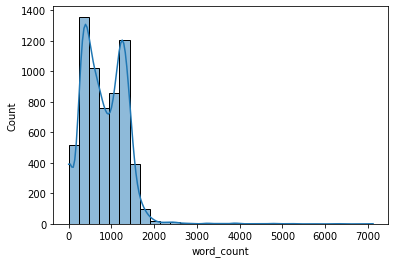

In [379]:
#Let's check the word count distribuition
sns.histplot(df_world["word_count"],kde=True, bins=30)

It looks like most of the articles are in the 0-2000 words range. We notice as well how the KDE distribuition has a positive skew, having some articles reaching up to 7000 words.

### 4.12 Date

Let's transform this feature in a more readeable format

In [380]:
df_world["date"]

0       2021-11-01T04:05:10+0000
1       2021-11-01T06:41:30+0000
2       2021-11-01T06:50:37+0000
3       2021-11-01T09:31:30+0000
4       2021-11-01T12:26:03+0000
                  ...           
6262    2020-11-30T12:57:55+0000
6263    2020-11-30T13:53:28+0000
6264    2020-11-30T15:07:04+0000
6265    2020-11-30T16:05:40+0000
6266    2020-11-30T16:35:23+0000
Name: date, Length: 6266, dtype: object

In [381]:
df_world["date"] = df_world['date'].astype('datetime64[D]').dt.date
df_world["date"]

0       2021-11-01
1       2021-11-01
2       2021-11-01
3       2021-11-01
4       2021-11-01
           ...    
6262    2020-11-30
6263    2020-11-30
6264    2020-11-30
6265    2020-11-30
6266    2020-11-30
Name: date, Length: 6266, dtype: object

# 5 Data Analysis

Let's create an unicus corpus first

In [382]:
corpus = " ".join(df_world["corpuses"])
corpus[:200]

'Once a Leading Polluter, the U.K. Is Now Trying to Lead on Climate ChangeOnce a Leading Polluter, Britain Is Trying to Lead on Climate ChangeLONDON — As Britain prepares to host a landmark climate sum'

Now let' create a function to disclose the lexical diversity

In [383]:
#let's check the lexical diversity

def lexical_diversity(corpus):
    """
    This function returns the vocabulary lenght and diversity score for our text data (the lower the better).

    Args:
        corpus (str): text to be scored

    Returns:
        int : diversity score
    
    """
    
    corpus = re.sub("\w*[0-9]\w*","",corpus) # remove all the text containing numbers
    
    tokenized = word_tokenize(corpus)
    
    vocab = set(tokenized)
    
    print("Vocabulary lenght: ",len(vocab), " words") , print("Diversity score: ", len(tokenized) / len(vocab))

lexical_diversity(corpus)

Vocabulary lenght:  41134  words
Diversity score:  13.399523508533086


It looks like our text is not so diverse. We are expecting this since often headlines, print headline, lead paragraph and abstracts contain the same words for the same topics.

#### Word Frequency

Now let's check the word frequency. We are going to create a text cleaner function first.

In [384]:
#let's create a text ceaner function to porcess our text
def text_cleaner(text, tokenized=0):
    """
    This function preprocess the text returning a string.
    
    It applies the following steps in this order: 
    punctuation removal, tokenization, removal of stop words, lemmatization.
    
    Args:
        text (str): text to be preprocessed
        tokenized (int, optional): Default = 0. Tokenize text if = 1 

    Returns:
        list: processed tokenized text if tokenized equals 1
        str: processed text
    """
    
    #Tokenize text
    # let's create a pattern to ignore
    pattern = r'''(?x)     # set flag to allow verbose regexps
      (?:[A-Z]\.)+       # abbreviations, e.g. U.S.
    | \w+(?:-\w+)*       # words with optional internal hyphens
    '''
    
    #create tokens excluding the pattern we just created
    tokens = nltk.regexp_tokenize(text, pattern) #tokenized text
            
    #Remove Stopwords - we apply this to normalized words
    stop_words = stopwords.words("english")
    stop_words.extend(["said","say","see", "new","say", "’", "‘","“", "”"])
    filtered_text = [word.rstrip().lstrip() for word in tokens if word.lower() not in stop_words] #rstrip().lstrip() to remove white spaces at the end and beginning fo the word
    
    #Lemmatize text - we want to keep the meaning of the words
    wordnet_lemmatizer  = WordNetLemmatizer()
    lemmatized_text = [wordnet_lemmatizer.lemmatize(word) for word in filtered_text ]
    
    if not tokenized == 1:
        lemmatized_text = " ".join(lemmatized_text)
    
    return lemmatized_text

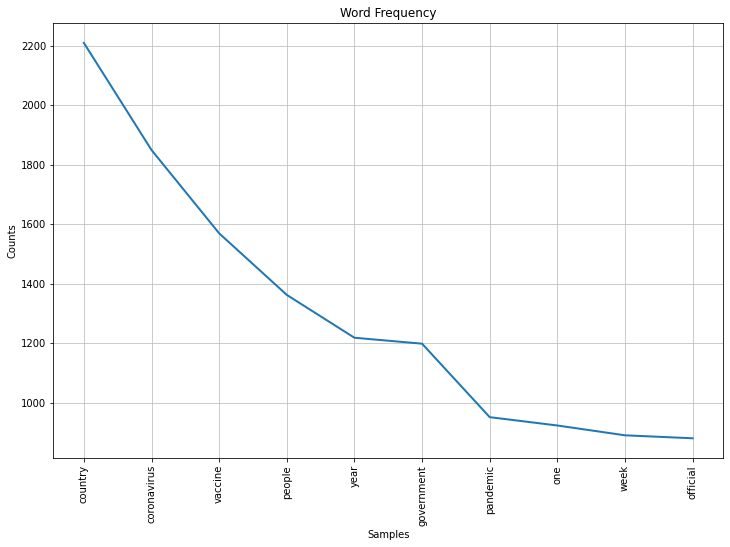

<Figure size 432x288 with 0 Axes>

In [385]:
#visualize word frequency
f_dist = FreqDist(nltk.tokenize.word_tokenize(text_cleaner(corpus)))

ax, fig = plt.subplots(figsize=(12,8))

ax = f_dist.plot(10, cumulative=False, title="Word Frequency")

plt.tight_layout()

In the top ten most used words we find 3 times a word related to Covid. That's not unexpected as Covid is still a relevant topic. (as per 1/11/21)

#### Article mean lenght per subsection

It would be interesting to check the mean article lenght per subsection to see what kind of articles take a longer time to read, but also which kind of articles are more verbose

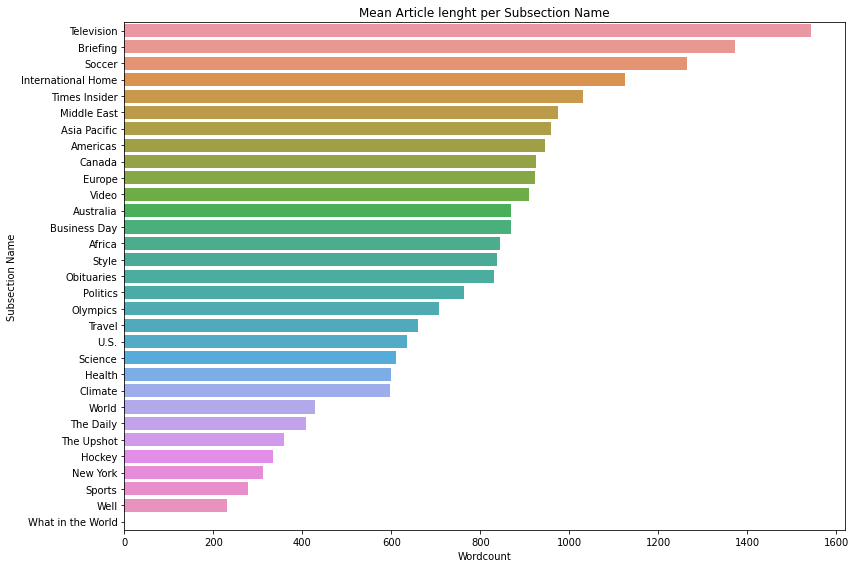

In [386]:
ax, fig = plt.subplots(figsize=(12,8))

order = df_world.groupby("subsection_name")["word_count"].mean().sort_values(ascending=False).index

ax = sns.barplot(y=df_world["subsection_name"], x=df_world["word_count"], order=order, orient="h", ci=None)

ax.set_title("Mean Article lenght per Subsection Name")
ax.set_ylabel("Subsection Name")
ax.set_xlabel("Wordcount")

plt.tight_layout()

Before we saw that the average reading time is 4 min. By this chart we can tell that the average longest articles are about television with a mean reading time of about 8 min. Also it's interesting to see that the longest articles are not country related. Middle east is the first world zone that we encounter followed by all the others. At the bottom we find a subsection with zero words - that's because it's a multimedia.

#### Top 20 Keywords

Let's give a look at the top 20 keywords used in this 12 months period

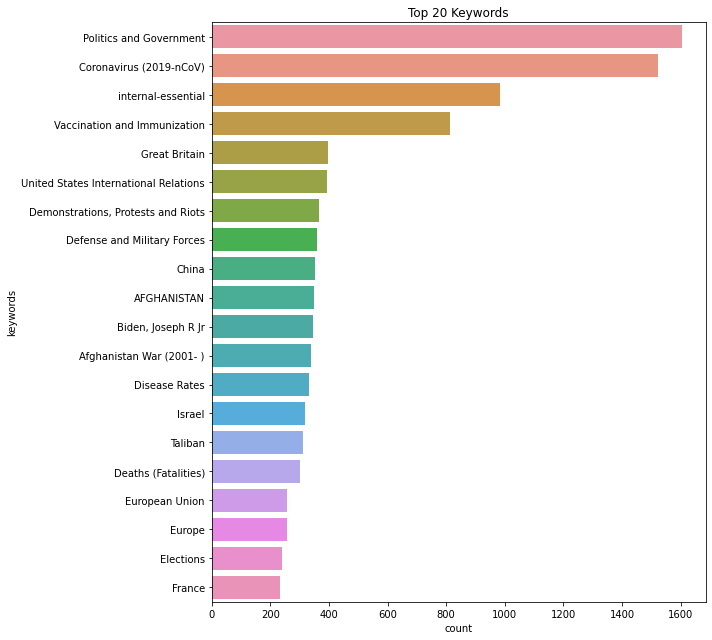

In [387]:
#let's visualise which are the top 20 keywords
ax, fig = plt.subplots(figsize=(10,9))

ax = sns.countplot(y ="keywords" ,data=df_world.explode("keywords"), order = df_world.explode("keywords").keywords.value_counts().iloc[:20].index)

ax.set_title("Top 20 Keywords")

plt.tight_layout()

Interesting enough Covid is not the first keyword, even tough Covid related keywords are most prominent accounting for about the 25% of the top 20 keywords. Also interesting that the first coutry mentioned as keyword is Great Britan ahead of China. Also Afghanistan related keywords are present for about the 15% of the top 20 words, suggesting the interest of foreign press on the Taliban ruling again the country.

#### Top Subsection

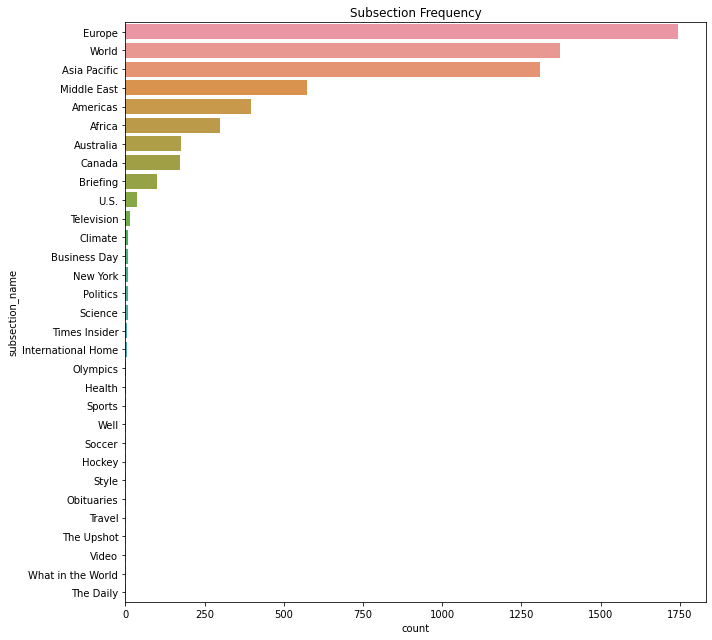

In [388]:
ax, fig = plt.subplots(figsize=(10,9))

order = df_world["subsection_name"].value_counts().index

ax = sns.countplot(y="subsection_name", data=df_world, order=order, orient="h")

ax.set_title("Subsection Frequency")

plt.tight_layout()

As seen before the, Europe is quite prominent topic in the NYT news. This migh be as well because of the spreading of the virus in this continent after China. It's important to note how even if Climate is on the middle top part of the graph, it is well behind the top 5 having less than 100 repetitions.

#### Wordcloud

Let's now visualize the most frequent words and bigramns

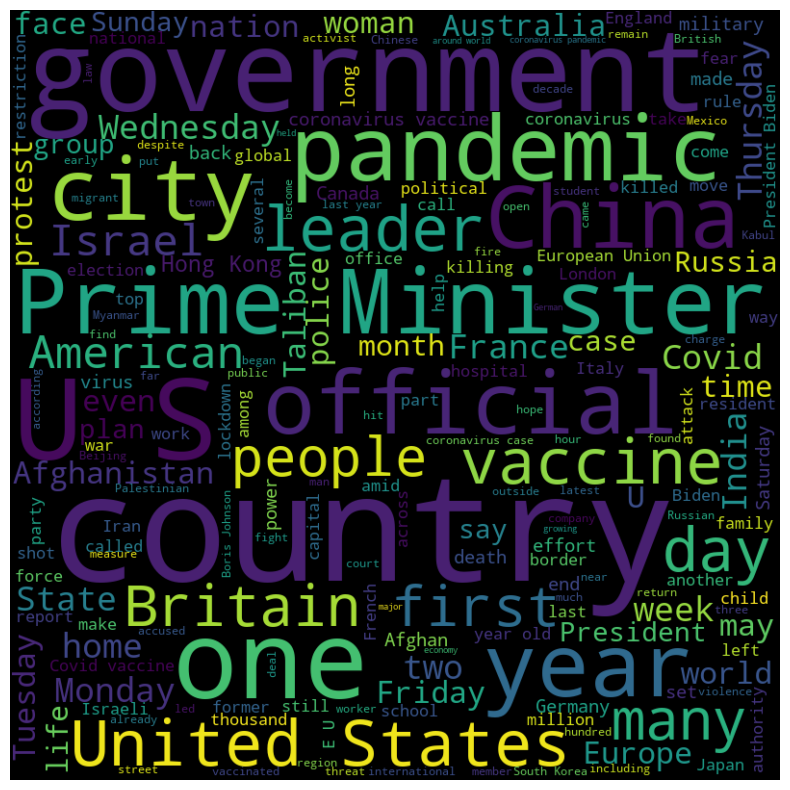

In [389]:
#Let's visualize the most used words in the corpus using Word Cloud
from wordcloud import WordCloud

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800, random_state=42).generate(text_cleaner(corpus))

ax, fig = plt.subplots(figsize=(8,8), dpi=100)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')

# bilinear interpolation is a way to spread the words out without them bumping into one another
plt.axis("off")
plt.tight_layout()
plt.show()


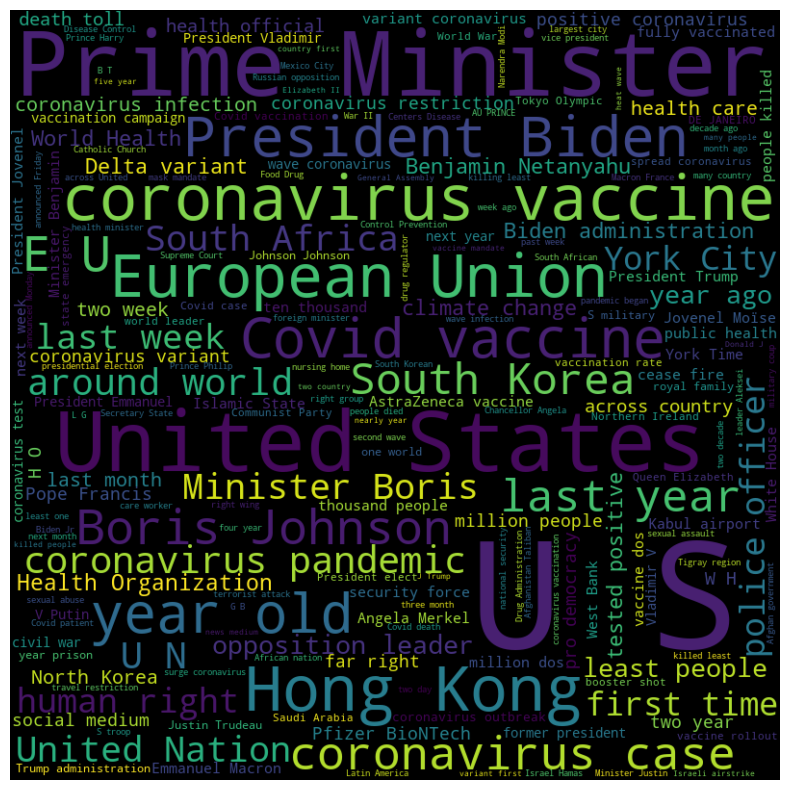

In [390]:
#le't do it again but considering bigrams
from wordcloud import WordCloud

# Create and generate a word cloud image:
wordcloud = WordCloud(width=800, height=800, collocation_threshold=3, random_state=42).generate(text_cleaner(corpus)) #lower collocation_threshold to show bigrams

ax, fig = plt.subplots(figsize=(8,8), dpi=100)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')

# bilinear interpolation is a way to spread the words out without them bumping into one another
plt.axis("off")
plt.tight_layout()
plt.show()

Wordclouds visualizations show us what we were expecting. Coronavirus is the most used word in both the images. Bigrams visualization give us a deeper insight on the topics showing how Coronavirus accounts for a large part of it but as well how countries and prime ministers are prominent. Sadly it's hart to spot any positive word, statement or bigram in both pictures.

#### Sentiment Analysis

Let's evaluate the sentiment analysis. We will create for this scope 3 new features

In [391]:
#Create instance of SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [392]:
#create new feature with the polarity
def polarity(row):
    pol = analyzer.polarity_scores(row)
    neg = pol["neg"]
    neu = pol["neu"]
    pos = pol["pos"]
    compound = pol["compound"]
    
    return pd.Series([neg, neu, pos, compound])

In [393]:
# Create 3 new features to estimate sentiment
df_world[["negative", "neutral", "positive", "compound"]] = df_world.apply(lambda row: polarity(row["corpuses"]), axis=1)

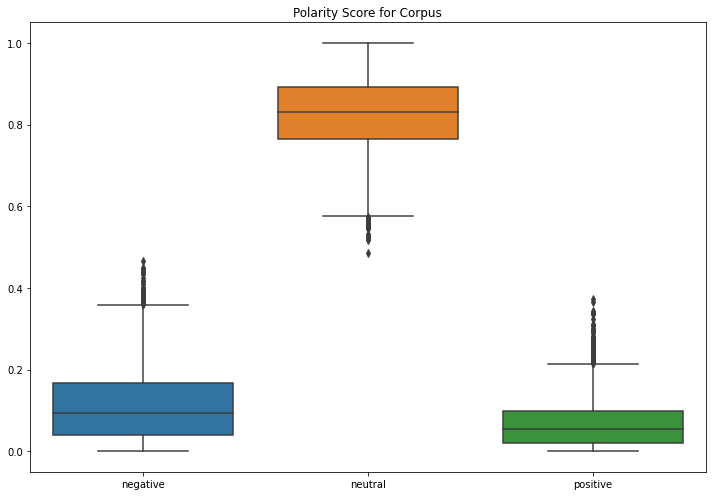

In [398]:
ax, fig = plt.subplots(figsize=(10,7))

ax = sns.boxplot(data=df_world[["negative","neutral","positive", "subsection_name"]])

ax.set_title("Polarity Score for Corpus")

plt.tight_layout()

All in all we can see how negative articles are dominant, having the 50 percentile of the negative articles higher than the 50 percentile of the positive.

# 6 Conclusions and Considerations

## 6.1 Summary of key findings

After the analysis the key fidnings are:

* Most used keyword in the world news section is not about Covid but about Politics and Government
* Covid related keywords are accounting for about 25% of the top 20 keywords
* Afghanistan related keywords account to 15% of the top 20 keywords
* Average read time for an article is 4 min
* Lexical diversity is low as expected since many news are about the same topic and using the same lexicon
* First used subsection is Europe ahead of other countries
* Longest articles are not country/politics related but rather sport and entertainment
* WordCloud gave us a picture of the main topic during the past 12 months. Interesting to see which are the most used bigrams - Covid is still the biggest topic
* Sentiment analysis showed a negative compound outlook over the past 12 months. That's no surprise with Covid spreading and still making a lot of deaths

## 6.2 Critical Analysis

As we were expecting in most of our analysis Covid was in the top positions. Even though the most used keyword it's about Politics and Governament, the sum of Covid related words outnumbers all the others. WorldCloud visualization showed how both in the monogram and in the bigram visualization Covid related words are predominant, this is also confirmed by the frequency plot. Generally speaking the balance of past 12 months has been negative as showed in the sentiment analysis boxplot, being the negative value higher than the positive. 

There were not so many surprises but it is iteresting to take a look at some features. In the Keywords feature for example the first country is U.K. ahead of all the others. This might be for multiple reasons: political, being Brexit still a big topic followed by the new trading deals with E.U. and U.S.A.; Covid related, considering that U.K. is the country with the highest death rate in Europe [[6]](#references_) but also first E.U. country that had a vaccine distributed to the public and being taken as benchmark for future decisions by other governaments. Also we can see that some of the keywords are referring to war zones or military in general, showing that even in these tough times there are still conflicts in some part of the world. There has been indeed great interest for the Afghan war and for the middle east, due to the fast reconquest of the capital Kabul by the Talibans. Also in the subsection feature we can see that Europe is the first of the top 20 keywords, probably this is due to covid reasons but also because of the ties that U.S.A. (being NYT a U.S. newspaper), and Asia Pacific is immediately following. It is interesting to notice as well that for more relaxing readings (such as television and sport) they are more verbose, implying that the public is more inclined to read long articles when they are about entertainment topics.

## 6.3 Conclusion and further work

Coming back the core of this study I reckon that being able to evaluate how the past year has been is easier to tell than to put in practice - especially from a machine standpoint. Even though there were not great unexpected findings it was interesting to find out how Covid is monopolizing the world newsand many other interesting topics have been partially eclipsed as for example for the climate topic. Sentiment analysis is a great tool but as far as this can be developed there will always be some flaws. Trying to sum up 12 month and making a computer "judge" on the times we are living is somewhat funny and intriguing at the same time. Even if it was not a surprise that the compound result of our analysis has been negative, I always ask myself, with a bit of a smile, whether newspapers ever give positive news in the first place. Of course they do but the negative ones outnumber the positive by far. It might be that we need to take a break from the news and live our life less influenced by them? This might be probably a good way to avoid absorbing less negativity, esplecially considering how depression, panic and anxiety have affected people during this period of lock down. Perhaps being a bit disconnected in a super connected world is not a bad idea.

Given these results, further work could focus more on sentiment analysis insights and the frequency of some words. For example analyze how different topics and sections have different sentiment analysis scores or in which topics certain words are most present. Also would be interesting to see how sentiment analysis evolved in time, analyzing for example what happened in that day in respect to an outlier negative or positive value. It would be interesting to see how the presence of some countries in the keywords chart evolved over time - expecting an evolution of the relevant countries in time due to the spread of the virus.

<a id="references_"></a>
# Refrences

[1] AMIT SINGH, , Hands-On Guide To Natural language Processing Using Spacy. Available: https://analyticsindiamag.com/nlp-deep-learning-nlp-framework-nlp-model/ [01/12/, 2021].

[2] VISHWAS B SHARMA, , rake-nltk. Available: https://github.com/csurfer/rake-nltk [01/12/, 2021]

[3] MAARTEN GROOTENDORST, KeyBERT, [01/12/,2021] (<a href="https://github.com/MaartenGr/KeyBERT">https://github.com/MaartenGr/KeyBERT</a>)

[4] MAARTEN GROOTENDORST, KeyBERT - Maximal Marginal Relevance, [01/12/,2021] (<a href="https://maartengr.github.io/KeyBERT/api/mmr.html">https://maartengr.github.io/KeyBERT/api/mmr.html</a>)

[5] CRIS TRAUTNER, , How to Calculate Reading Time. Available: https://infusion.media/content-marketing/how-to-calculate-reading-time/ [01/12/21]

[6] Worldometers.info, Available: https://www.worldometers.info [14/12/2021]